## Mass-Spring-Damper System: A Classical Mechanical System

![Mass-Spring-Damper System](./images/Mass_spring_damper.png)

The system encompasses:

- **Mass (m):** Resisting acceleration, this component is influenced by external forces.
- **Spring (k):** A force proportional to the mass's displacement from equilibrium is exerted by this component.
- **Damper (c):** Opposing the mass's motion, this component provides a force proportional to its velocity.

When the mass is displaced and then released, oscillations occur around its equilibrium due to the spring's restoring force and the damper's resistance. 

### Deriving the State-Space Model

**Physical Equations:**  
Starting with Newton's second law: 
$$ F = ma $$

The external force \( F \) is counteracted by the spring and damping forces, thus:
$$ F_{\text{external}} - kx - cv = ma $$

Where:

- Hooke's law, with x as displacement $$ F_{\text{spring}} = kx $$
- v is the velocity $$ F_{\text{damper}} = cv $$

**State Variables:**  
Choosing:
- Displacement $$ x_1 = x $$  
- Velocity $$ x_2 = v $$

Their derivatives:
$$ \dot{x}_1 = x_2 $$
$$ \dot{x}_2 = a $$

Substituting these into our derived equations, we can represent the system in state-space form:

$$ \begin{align*}
\dot{x} &= Ax + Bu \\
y &= Cx + Du \\
\end{align*} $$

Where:  
$$ A = \begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & -\frac{c}{m} \end{bmatrix} $$
$$ B = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} $$
$$ C = \begin{bmatrix} 1 & 0 \end{bmatrix} $$
$$ D = \begin{bmatrix} 0 \end{bmatrix} $$

## Simulation Overview

In this simulation, we aim to understand the behavior and dynamics of the Mass-Spring-Damper system under various conditions, utilizing a neural network model to emulate its behavior given certain inputs and initial states.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Model definition
First we need to define the system matrices of the state-space model. This is a continuous-time model, we will simulate it using the backwar Euler method.

Physical parameters

In [2]:
m = 100.0  # mass (kg)
c = 0.1  # damping coefficient (N.s/m)
k = 1.0  # spring constant (N/m)

State-space representation

In [3]:
A = np.matrix([[0,1], [-k/m, -c/m]])
B = np.matrix([[0],[1/m]])
C = np.matrix([[1, 0]])

Time and sampling

In [4]:
time=1000
sampling=2

### Data Generation

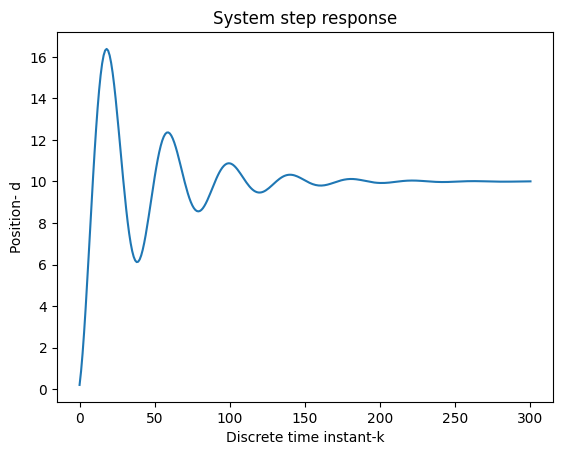

In [5]:
from backward_euler import simulate

def generate_data(A, B, C, time, sampling, input_range=(-1, 1)):
    """Generate training, validation, and test data."""

    # Create a new random input sequence and a new random initial condition
    # Use np.random.randn for a normal distribution and then scale and shift it
    input_seq = np.random.randn(time, 1) * (input_range[1] - input_range[0]) / 2 + (input_range[1] + input_range[0]) / 2
    x0 = np.random.randn(2, 1) * (input_range[1] - input_range[0]) / 2 + (input_range[1] + input_range[0]) / 2

    # Add random noise to the input sequence
    noise_strength = 0.05  # Adjust this value to increase or decrease the noise strength
    input_seq += np.random.randn(time, 1) * noise_strength

    # Simulate the system
    state, output = simulate(A, B, C, x0, input_seq, time, sampling)
    output = output.T
    output = np.reshape(output, (1, output.shape[0], 1))

    # Reshape input sequence
    input_seq = np.reshape(input_seq, (input_seq.shape[0], 1))
    tmp = np.concatenate((input_seq, np.zeros(shape=(input_seq.shape[0], 1))), axis=1)
    tmp = np.concatenate((x0.T, tmp), axis=0)

    # This is the input data used for the respective dataset
    inputX = np.reshape(tmp, (1, tmp.shape[0], tmp.shape[1]))

    return inputX, output

In [6]:
trainX, output_train = generate_data(A, B, C, time, sampling)
validateX, output_validate = generate_data(A, B, C, time, sampling)
testX, output_test = generate_data(A, B, C, time, sampling)

### Network Definition

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.optimizers import RMSprop
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [8]:
model=Sequential()
#model.add(SimpleRNN(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
#model.add(GRU(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(Dense(1))
model.add(TimeDistributed(Dense(1)))  #there is no difference between this and model.add(Dense(1))...
# does not make sense to use metrics=['acc'], see https://stackoverflow.com/questions/41819457/zero-accuracy-training-a-neural-network-in-keras
model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])

In [9]:
# after every epoch, we save the model, this is the absolute path on my C: drive, so the path is
# C:\python_files\system_identification\models\
filepath="models/weights-{epoch:02d}-{val_loss:.6f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
callbacks_list = [checkpoint]
history=model.fit(trainX, output_train , epochs=2000, batch_size=1, callbacks=callbacks_list, validation_data=(validateX,output_validate), verbose=2)

Epoch 1/2000
1/1 - 10s - loss: 0.8162 - mse: 0.8162 - val_loss: 1.4589 - val_mse: 1.4589 - 10s/epoch - 10s/step
Epoch 2/2000
1/1 - 1s - loss: 0.8151 - mse: 0.8151 - val_loss: 1.4582 - val_mse: 1.4582 - 522ms/epoch - 522ms/step
Epoch 3/2000
1/1 - 1s - loss: 0.8142 - mse: 0.8142 - val_loss: 1.4575 - val_mse: 1.4575 - 536ms/epoch - 536ms/step
Epoch 4/2000
1/1 - 1s - loss: 0.8133 - mse: 0.8133 - val_loss: 1.4567 - val_mse: 1.4567 - 519ms/epoch - 519ms/step
Epoch 5/2000
1/1 - 1s - loss: 0.8124 - mse: 0.8124 - val_loss: 1.4559 - val_mse: 1.4559 - 517ms/epoch - 517ms/step
Epoch 6/2000
1/1 - 1s - loss: 0.8115 - mse: 0.8115 - val_loss: 1.4550 - val_mse: 1.4550 - 518ms/epoch - 518ms/step
Epoch 7/2000
1/1 - 0s - loss: 0.8105 - mse: 0.8105 - val_loss: 1.4541 - val_mse: 1.4541 - 467ms/epoch - 467ms/step
Epoch 8/2000
1/1 - 0s - loss: 0.8094 - mse: 0.8094 - val_loss: 1.4530 - val_mse: 1.4530 - 484ms/epoch - 484ms/step
Epoch 9/2000
1/1 - 0s - loss: 0.8082 - mse: 0.8082 - val_loss: 1.4519 - val_mse: 1.

Epoch 72/2000
1/1 - 0s - loss: 0.6407 - mse: 0.6407 - val_loss: 1.1975 - val_mse: 1.1975 - 487ms/epoch - 487ms/step
Epoch 73/2000
1/1 - 0s - loss: 0.6627 - mse: 0.6627 - val_loss: 1.2650 - val_mse: 1.2650 - 485ms/epoch - 485ms/step
Epoch 74/2000
1/1 - 1s - loss: 0.6195 - mse: 0.6195 - val_loss: 1.3055 - val_mse: 1.3055 - 510ms/epoch - 510ms/step
Epoch 75/2000
1/1 - 1s - loss: 0.6141 - mse: 0.6141 - val_loss: 1.3044 - val_mse: 1.3044 - 504ms/epoch - 504ms/step
Epoch 76/2000
1/1 - 1s - loss: 0.6114 - mse: 0.6114 - val_loss: 1.3013 - val_mse: 1.3013 - 529ms/epoch - 529ms/step
Epoch 77/2000
1/1 - 0s - loss: 0.6089 - mse: 0.6089 - val_loss: 1.2959 - val_mse: 1.2959 - 496ms/epoch - 496ms/step
Epoch 78/2000
1/1 - 0s - loss: 0.6064 - mse: 0.6064 - val_loss: 1.2955 - val_mse: 1.2955 - 488ms/epoch - 488ms/step
Epoch 79/2000
1/1 - 1s - loss: 0.6039 - mse: 0.6039 - val_loss: 1.2858 - val_mse: 1.2858 - 533ms/epoch - 533ms/step
Epoch 80/2000
1/1 - 0s - loss: 0.6014 - mse: 0.6014 - val_loss: 1.2944 -

Epoch 143/2000
1/1 - 0s - loss: 0.4282 - mse: 0.4282 - val_loss: 1.1426 - val_mse: 1.1426 - 466ms/epoch - 466ms/step
Epoch 144/2000
1/1 - 1s - loss: 0.4244 - mse: 0.4244 - val_loss: 1.2319 - val_mse: 1.2319 - 506ms/epoch - 506ms/step
Epoch 145/2000
1/1 - 1s - loss: 0.4234 - mse: 0.4234 - val_loss: 1.1521 - val_mse: 1.1521 - 501ms/epoch - 501ms/step
Epoch 146/2000
1/1 - 0s - loss: 0.4234 - mse: 0.4234 - val_loss: 1.2266 - val_mse: 1.2266 - 473ms/epoch - 473ms/step
Epoch 147/2000
1/1 - 0s - loss: 0.4196 - mse: 0.4196 - val_loss: 1.1661 - val_mse: 1.1661 - 486ms/epoch - 486ms/step
Epoch 148/2000
1/1 - 0s - loss: 0.4199 - mse: 0.4199 - val_loss: 1.1973 - val_mse: 1.1973 - 498ms/epoch - 498ms/step
Epoch 149/2000
1/1 - 0s - loss: 0.4101 - mse: 0.4101 - val_loss: 1.1784 - val_mse: 1.1784 - 486ms/epoch - 486ms/step
Epoch 150/2000
1/1 - 0s - loss: 0.4104 - mse: 0.4104 - val_loss: 1.1754 - val_mse: 1.1754 - 479ms/epoch - 479ms/step
Epoch 151/2000
1/1 - 0s - loss: 0.4042 - mse: 0.4042 - val_loss:

1/1 - 0s - loss: 0.2534 - mse: 0.2534 - val_loss: 1.2370 - val_mse: 1.2370 - 182ms/epoch - 182ms/step
Epoch 214/2000
1/1 - 0s - loss: 0.2434 - mse: 0.2434 - val_loss: 1.4034 - val_mse: 1.4034 - 220ms/epoch - 220ms/step
Epoch 215/2000
1/1 - 0s - loss: 0.2551 - mse: 0.2551 - val_loss: 1.2075 - val_mse: 1.2075 - 222ms/epoch - 222ms/step
Epoch 216/2000
1/1 - 0s - loss: 0.2540 - mse: 0.2540 - val_loss: 1.3882 - val_mse: 1.3882 - 198ms/epoch - 198ms/step
Epoch 217/2000
1/1 - 0s - loss: 0.2483 - mse: 0.2483 - val_loss: 1.1913 - val_mse: 1.1913 - 211ms/epoch - 211ms/step
Epoch 218/2000
1/1 - 0s - loss: 0.2452 - mse: 0.2452 - val_loss: 1.3489 - val_mse: 1.3489 - 270ms/epoch - 270ms/step
Epoch 219/2000
1/1 - 0s - loss: 0.2356 - mse: 0.2356 - val_loss: 1.2101 - val_mse: 1.2101 - 248ms/epoch - 248ms/step
Epoch 220/2000
1/1 - 0s - loss: 0.2311 - mse: 0.2311 - val_loss: 1.3436 - val_mse: 1.3436 - 200ms/epoch - 200ms/step
Epoch 221/2000
1/1 - 0s - loss: 0.2367 - mse: 0.2367 - val_loss: 1.2402 - val_m

Epoch 284/2000
1/1 - 0s - loss: 0.1252 - mse: 0.1252 - val_loss: 1.0972 - val_mse: 1.0972 - 204ms/epoch - 204ms/step
Epoch 285/2000
1/1 - 0s - loss: 0.1365 - mse: 0.1365 - val_loss: 1.0675 - val_mse: 1.0675 - 199ms/epoch - 199ms/step
Epoch 286/2000
1/1 - 0s - loss: 0.1244 - mse: 0.1244 - val_loss: 1.1261 - val_mse: 1.1261 - 220ms/epoch - 220ms/step
Epoch 287/2000
1/1 - 0s - loss: 0.1462 - mse: 0.1462 - val_loss: 1.0355 - val_mse: 1.0355 - 216ms/epoch - 216ms/step
Epoch 288/2000
1/1 - 0s - loss: 0.1179 - mse: 0.1179 - val_loss: 1.1153 - val_mse: 1.1153 - 206ms/epoch - 206ms/step
Epoch 289/2000
1/1 - 0s - loss: 0.1270 - mse: 0.1270 - val_loss: 1.0170 - val_mse: 1.0170 - 203ms/epoch - 203ms/step
Epoch 290/2000
1/1 - 0s - loss: 0.1237 - mse: 0.1237 - val_loss: 1.1877 - val_mse: 1.1877 - 198ms/epoch - 198ms/step
Epoch 291/2000
1/1 - 0s - loss: 0.1474 - mse: 0.1474 - val_loss: 0.9866 - val_mse: 0.9866 - 205ms/epoch - 205ms/step
Epoch 292/2000
1/1 - 0s - loss: 0.1165 - mse: 0.1165 - val_loss:

1/1 - 0s - loss: 0.0595 - mse: 0.0595 - val_loss: 0.8568 - val_mse: 0.8568 - 208ms/epoch - 208ms/step
Epoch 355/2000
1/1 - 0s - loss: 0.0698 - mse: 0.0698 - val_loss: 0.8312 - val_mse: 0.8312 - 199ms/epoch - 199ms/step
Epoch 356/2000
1/1 - 0s - loss: 0.0580 - mse: 0.0580 - val_loss: 0.8776 - val_mse: 0.8776 - 184ms/epoch - 184ms/step
Epoch 357/2000
1/1 - 0s - loss: 0.0772 - mse: 0.0772 - val_loss: 0.8042 - val_mse: 0.8042 - 208ms/epoch - 208ms/step
Epoch 358/2000
1/1 - 0s - loss: 0.0597 - mse: 0.0597 - val_loss: 0.9033 - val_mse: 0.9033 - 195ms/epoch - 195ms/step
Epoch 359/2000
1/1 - 0s - loss: 0.0726 - mse: 0.0726 - val_loss: 0.7706 - val_mse: 0.7706 - 216ms/epoch - 216ms/step
Epoch 360/2000
1/1 - 0s - loss: 0.0660 - mse: 0.0660 - val_loss: 0.9387 - val_mse: 0.9387 - 200ms/epoch - 200ms/step
Epoch 361/2000
1/1 - 0s - loss: 0.0742 - mse: 0.0742 - val_loss: 0.7494 - val_mse: 0.7494 - 194ms/epoch - 194ms/step
Epoch 362/2000
1/1 - 0s - loss: 0.0650 - mse: 0.0650 - val_loss: 0.9482 - val_m

Epoch 425/2000
1/1 - 0s - loss: 0.0482 - mse: 0.0482 - val_loss: 0.7372 - val_mse: 0.7372 - 189ms/epoch - 189ms/step
Epoch 426/2000
1/1 - 0s - loss: 0.0362 - mse: 0.0362 - val_loss: 0.8639 - val_mse: 0.8639 - 180ms/epoch - 180ms/step
Epoch 427/2000
1/1 - 0s - loss: 0.0565 - mse: 0.0565 - val_loss: 0.7315 - val_mse: 0.7315 - 201ms/epoch - 201ms/step
Epoch 428/2000
1/1 - 0s - loss: 0.0456 - mse: 0.0456 - val_loss: 0.8612 - val_mse: 0.8612 - 305ms/epoch - 305ms/step
Epoch 429/2000
1/1 - 0s - loss: 0.0497 - mse: 0.0497 - val_loss: 0.7251 - val_mse: 0.7251 - 185ms/epoch - 185ms/step
Epoch 430/2000
1/1 - 0s - loss: 0.0433 - mse: 0.0433 - val_loss: 0.8635 - val_mse: 0.8635 - 224ms/epoch - 224ms/step
Epoch 431/2000
1/1 - 0s - loss: 0.0425 - mse: 0.0425 - val_loss: 0.7216 - val_mse: 0.7216 - 198ms/epoch - 198ms/step
Epoch 432/2000
1/1 - 0s - loss: 0.0405 - mse: 0.0405 - val_loss: 0.8742 - val_mse: 0.8742 - 200ms/epoch - 200ms/step
Epoch 433/2000
1/1 - 0s - loss: 0.0421 - mse: 0.0421 - val_loss:

1/1 - 0s - loss: 0.0351 - mse: 0.0351 - val_loss: 0.7488 - val_mse: 0.7488 - 220ms/epoch - 220ms/step
Epoch 496/2000
1/1 - 0s - loss: 0.0235 - mse: 0.0235 - val_loss: 0.8104 - val_mse: 0.8104 - 201ms/epoch - 201ms/step
Epoch 497/2000
1/1 - 0s - loss: 0.0346 - mse: 0.0346 - val_loss: 0.7342 - val_mse: 0.7342 - 221ms/epoch - 221ms/step
Epoch 498/2000
1/1 - 0s - loss: 0.0251 - mse: 0.0251 - val_loss: 0.8491 - val_mse: 0.8491 - 240ms/epoch - 240ms/step
Epoch 499/2000
1/1 - 0s - loss: 0.0454 - mse: 0.0454 - val_loss: 0.7235 - val_mse: 0.7235 - 216ms/epoch - 216ms/step
Epoch 500/2000
1/1 - 0s - loss: 0.0355 - mse: 0.0355 - val_loss: 0.8613 - val_mse: 0.8613 - 191ms/epoch - 191ms/step
Epoch 501/2000
1/1 - 0s - loss: 0.0464 - mse: 0.0464 - val_loss: 0.7196 - val_mse: 0.7196 - 205ms/epoch - 205ms/step
Epoch 502/2000
1/1 - 0s - loss: 0.0394 - mse: 0.0394 - val_loss: 0.8504 - val_mse: 0.8504 - 199ms/epoch - 199ms/step
Epoch 503/2000
1/1 - 0s - loss: 0.0358 - mse: 0.0358 - val_loss: 0.7161 - val_m

Epoch 566/2000
1/1 - 0s - loss: 0.0349 - mse: 0.0349 - val_loss: 0.8517 - val_mse: 0.8517 - 249ms/epoch - 249ms/step
Epoch 567/2000
1/1 - 0s - loss: 0.0519 - mse: 0.0519 - val_loss: 0.7377 - val_mse: 0.7377 - 262ms/epoch - 262ms/step
Epoch 568/2000
1/1 - 0s - loss: 0.0293 - mse: 0.0293 - val_loss: 0.7702 - val_mse: 0.7702 - 211ms/epoch - 211ms/step
Epoch 569/2000
1/1 - 0s - loss: 0.0295 - mse: 0.0295 - val_loss: 0.7495 - val_mse: 0.7495 - 282ms/epoch - 282ms/step
Epoch 570/2000
1/1 - 0s - loss: 0.0245 - mse: 0.0245 - val_loss: 0.7659 - val_mse: 0.7659 - 366ms/epoch - 366ms/step
Epoch 571/2000
1/1 - 0s - loss: 0.0294 - mse: 0.0294 - val_loss: 0.7467 - val_mse: 0.7467 - 351ms/epoch - 351ms/step
Epoch 572/2000
1/1 - 0s - loss: 0.0202 - mse: 0.0202 - val_loss: 0.7746 - val_mse: 0.7746 - 257ms/epoch - 257ms/step
Epoch 573/2000
1/1 - 0s - loss: 0.0302 - mse: 0.0302 - val_loss: 0.7292 - val_mse: 0.7292 - 258ms/epoch - 258ms/step
Epoch 574/2000
1/1 - 0s - loss: 0.0195 - mse: 0.0195 - val_loss:

1/1 - 0s - loss: 0.0304 - mse: 0.0304 - val_loss: 0.8520 - val_mse: 0.8520 - 189ms/epoch - 189ms/step
Epoch 637/2000
1/1 - 0s - loss: 0.0358 - mse: 0.0358 - val_loss: 0.7074 - val_mse: 0.7074 - 194ms/epoch - 194ms/step
Epoch 638/2000
1/1 - 0s - loss: 0.0294 - mse: 0.0294 - val_loss: 0.8480 - val_mse: 0.8480 - 186ms/epoch - 186ms/step
Epoch 639/2000
1/1 - 0s - loss: 0.0260 - mse: 0.0260 - val_loss: 0.7083 - val_mse: 0.7083 - 203ms/epoch - 203ms/step
Epoch 640/2000
1/1 - 0s - loss: 0.0222 - mse: 0.0222 - val_loss: 0.8434 - val_mse: 0.8434 - 229ms/epoch - 229ms/step
Epoch 641/2000
1/1 - 0s - loss: 0.0220 - mse: 0.0220 - val_loss: 0.7087 - val_mse: 0.7087 - 202ms/epoch - 202ms/step
Epoch 642/2000
1/1 - 0s - loss: 0.0217 - mse: 0.0217 - val_loss: 0.8531 - val_mse: 0.8531 - 207ms/epoch - 207ms/step
Epoch 643/2000
1/1 - 0s - loss: 0.0291 - mse: 0.0291 - val_loss: 0.7262 - val_mse: 0.7262 - 189ms/epoch - 189ms/step
Epoch 644/2000
1/1 - 0s - loss: 0.0303 - mse: 0.0303 - val_loss: 0.8606 - val_m

Epoch 707/2000
1/1 - 0s - loss: 0.0258 - mse: 0.0258 - val_loss: 0.8335 - val_mse: 0.8335 - 192ms/epoch - 192ms/step
Epoch 708/2000
1/1 - 0s - loss: 0.0209 - mse: 0.0209 - val_loss: 0.7895 - val_mse: 0.7895 - 192ms/epoch - 192ms/step
Epoch 709/2000
1/1 - 0s - loss: 0.0246 - mse: 0.0246 - val_loss: 0.8447 - val_mse: 0.8447 - 199ms/epoch - 199ms/step
Epoch 710/2000
1/1 - 0s - loss: 0.0173 - mse: 0.0173 - val_loss: 0.7951 - val_mse: 0.7951 - 207ms/epoch - 207ms/step
Epoch 711/2000
1/1 - 0s - loss: 0.0272 - mse: 0.0272 - val_loss: 0.8264 - val_mse: 0.8264 - 185ms/epoch - 185ms/step
Epoch 712/2000
1/1 - 0s - loss: 0.0146 - mse: 0.0146 - val_loss: 0.8157 - val_mse: 0.8157 - 185ms/epoch - 185ms/step
Epoch 713/2000
1/1 - 0s - loss: 0.0253 - mse: 0.0253 - val_loss: 0.8028 - val_mse: 0.8028 - 179ms/epoch - 179ms/step
Epoch 714/2000
1/1 - 0s - loss: 0.0188 - mse: 0.0188 - val_loss: 0.8649 - val_mse: 0.8649 - 202ms/epoch - 202ms/step
Epoch 715/2000
1/1 - 0s - loss: 0.0350 - mse: 0.0350 - val_loss:

1/1 - 0s - loss: 0.0318 - mse: 0.0318 - val_loss: 0.7919 - val_mse: 0.7919 - 183ms/epoch - 183ms/step
Epoch 778/2000
1/1 - 0s - loss: 0.0254 - mse: 0.0254 - val_loss: 0.9392 - val_mse: 0.9392 - 183ms/epoch - 183ms/step
Epoch 779/2000
1/1 - 0s - loss: 0.0264 - mse: 0.0264 - val_loss: 0.7847 - val_mse: 0.7847 - 199ms/epoch - 199ms/step
Epoch 780/2000
1/1 - 0s - loss: 0.0211 - mse: 0.0211 - val_loss: 0.9371 - val_mse: 0.9371 - 231ms/epoch - 231ms/step
Epoch 781/2000
1/1 - 0s - loss: 0.0195 - mse: 0.0195 - val_loss: 0.7860 - val_mse: 0.7860 - 214ms/epoch - 214ms/step
Epoch 782/2000
1/1 - 0s - loss: 0.0172 - mse: 0.0172 - val_loss: 0.9364 - val_mse: 0.9364 - 198ms/epoch - 198ms/step
Epoch 783/2000
1/1 - 0s - loss: 0.0183 - mse: 0.0183 - val_loss: 0.7905 - val_mse: 0.7905 - 205ms/epoch - 205ms/step
Epoch 784/2000
1/1 - 0s - loss: 0.0189 - mse: 0.0189 - val_loss: 0.9407 - val_mse: 0.9407 - 183ms/epoch - 183ms/step
Epoch 785/2000
1/1 - 0s - loss: 0.0291 - mse: 0.0291 - val_loss: 0.8337 - val_m

Epoch 848/2000
1/1 - 0s - loss: 0.0223 - mse: 0.0223 - val_loss: 0.9678 - val_mse: 0.9678 - 214ms/epoch - 214ms/step
Epoch 849/2000
1/1 - 0s - loss: 0.0407 - mse: 0.0407 - val_loss: 0.9016 - val_mse: 0.9016 - 187ms/epoch - 187ms/step
Epoch 850/2000
1/1 - 0s - loss: 0.0291 - mse: 0.0291 - val_loss: 0.8937 - val_mse: 0.8937 - 183ms/epoch - 183ms/step
Epoch 851/2000
1/1 - 0s - loss: 0.0303 - mse: 0.0303 - val_loss: 0.9265 - val_mse: 0.9265 - 199ms/epoch - 199ms/step
Epoch 852/2000
1/1 - 0s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.8547 - val_mse: 0.8547 - 186ms/epoch - 186ms/step
Epoch 853/2000
1/1 - 0s - loss: 0.0222 - mse: 0.0222 - val_loss: 0.9405 - val_mse: 0.9405 - 179ms/epoch - 179ms/step
Epoch 854/2000
1/1 - 0s - loss: 0.0147 - mse: 0.0147 - val_loss: 0.8520 - val_mse: 0.8520 - 214ms/epoch - 214ms/step
Epoch 855/2000
1/1 - 0s - loss: 0.0239 - mse: 0.0239 - val_loss: 0.9244 - val_mse: 0.9244 - 198ms/epoch - 198ms/step
Epoch 856/2000
1/1 - 0s - loss: 0.0125 - mse: 0.0125 - val_loss:

1/1 - 0s - loss: 0.0137 - mse: 0.0137 - val_loss: 0.8726 - val_mse: 0.8726 - 208ms/epoch - 208ms/step
Epoch 919/2000
1/1 - 0s - loss: 0.0227 - mse: 0.0227 - val_loss: 0.9529 - val_mse: 0.9529 - 177ms/epoch - 177ms/step
Epoch 920/2000
1/1 - 0s - loss: 0.0118 - mse: 0.0118 - val_loss: 0.8940 - val_mse: 0.8940 - 196ms/epoch - 196ms/step
Epoch 921/2000
1/1 - 0s - loss: 0.0199 - mse: 0.0199 - val_loss: 0.9290 - val_mse: 0.9290 - 189ms/epoch - 189ms/step
Epoch 922/2000
1/1 - 0s - loss: 0.0137 - mse: 0.0137 - val_loss: 0.9315 - val_mse: 0.9315 - 175ms/epoch - 175ms/step
Epoch 923/2000
1/1 - 0s - loss: 0.0239 - mse: 0.0239 - val_loss: 0.8908 - val_mse: 0.8908 - 181ms/epoch - 181ms/step
Epoch 924/2000
1/1 - 0s - loss: 0.0163 - mse: 0.0163 - val_loss: 0.9730 - val_mse: 0.9730 - 168ms/epoch - 168ms/step
Epoch 925/2000
1/1 - 0s - loss: 0.0244 - mse: 0.0244 - val_loss: 0.8552 - val_mse: 0.8552 - 196ms/epoch - 196ms/step
Epoch 926/2000
1/1 - 0s - loss: 0.0192 - mse: 0.0192 - val_loss: 1.0007 - val_m

Epoch 989/2000
1/1 - 0s - loss: 0.0232 - mse: 0.0232 - val_loss: 0.9035 - val_mse: 0.9035 - 184ms/epoch - 184ms/step
Epoch 990/2000
1/1 - 0s - loss: 0.0158 - mse: 0.0158 - val_loss: 1.0069 - val_mse: 1.0069 - 181ms/epoch - 181ms/step
Epoch 991/2000
1/1 - 0s - loss: 0.0221 - mse: 0.0221 - val_loss: 0.8778 - val_mse: 0.8778 - 214ms/epoch - 214ms/step
Epoch 992/2000
1/1 - 0s - loss: 0.0168 - mse: 0.0168 - val_loss: 1.0244 - val_mse: 1.0244 - 184ms/epoch - 184ms/step
Epoch 993/2000
1/1 - 0s - loss: 0.0189 - mse: 0.0189 - val_loss: 0.8719 - val_mse: 0.8719 - 200ms/epoch - 200ms/step
Epoch 994/2000
1/1 - 0s - loss: 0.0149 - mse: 0.0149 - val_loss: 1.0292 - val_mse: 1.0292 - 167ms/epoch - 167ms/step
Epoch 995/2000
1/1 - 0s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.8707 - val_mse: 0.8707 - 185ms/epoch - 185ms/step
Epoch 996/2000
1/1 - 0s - loss: 0.0137 - mse: 0.0137 - val_loss: 1.0335 - val_mse: 1.0335 - 183ms/epoch - 183ms/step
Epoch 997/2000
1/1 - 0s - loss: 0.0154 - mse: 0.0154 - val_loss:

Epoch 1059/2000
1/1 - 0s - loss: 0.0183 - mse: 0.0183 - val_loss: 0.8996 - val_mse: 0.8996 - 180ms/epoch - 180ms/step
Epoch 1060/2000
1/1 - 0s - loss: 0.0145 - mse: 0.0145 - val_loss: 1.0621 - val_mse: 1.0621 - 200ms/epoch - 200ms/step
Epoch 1061/2000
1/1 - 0s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.8942 - val_mse: 0.8942 - 185ms/epoch - 185ms/step
Epoch 1062/2000
1/1 - 0s - loss: 0.0135 - mse: 0.0135 - val_loss: 1.0720 - val_mse: 1.0720 - 199ms/epoch - 199ms/step
Epoch 1063/2000
1/1 - 0s - loss: 0.0145 - mse: 0.0145 - val_loss: 0.8911 - val_mse: 0.8911 - 183ms/epoch - 183ms/step
Epoch 1064/2000
1/1 - 0s - loss: 0.0136 - mse: 0.0136 - val_loss: 1.0792 - val_mse: 1.0792 - 187ms/epoch - 187ms/step
Epoch 1065/2000
1/1 - 0s - loss: 0.0147 - mse: 0.0147 - val_loss: 0.8991 - val_mse: 0.8991 - 214ms/epoch - 214ms/step
Epoch 1066/2000
1/1 - 0s - loss: 0.0155 - mse: 0.0155 - val_loss: 1.0688 - val_mse: 1.0688 - 167ms/epoch - 167ms/step
Epoch 1067/2000
1/1 - 0s - loss: 0.0211 - mse: 0.0211 - 

Epoch 1129/2000
1/1 - 0s - loss: 0.0133 - mse: 0.0133 - val_loss: 0.9917 - val_mse: 0.9917 - 167ms/epoch - 167ms/step
Epoch 1130/2000
1/1 - 0s - loss: 0.0191 - mse: 0.0191 - val_loss: 1.0379 - val_mse: 1.0379 - 182ms/epoch - 182ms/step
Epoch 1131/2000
1/1 - 0s - loss: 0.0111 - mse: 0.0111 - val_loss: 0.9766 - val_mse: 0.9766 - 201ms/epoch - 201ms/step
Epoch 1132/2000
1/1 - 0s - loss: 0.0154 - mse: 0.0154 - val_loss: 1.0470 - val_mse: 1.0470 - 182ms/epoch - 182ms/step
Epoch 1133/2000
1/1 - 0s - loss: 0.0101 - mse: 0.0101 - val_loss: 0.9647 - val_mse: 0.9647 - 201ms/epoch - 201ms/step
Epoch 1134/2000
1/1 - 0s - loss: 0.0170 - mse: 0.0170 - val_loss: 1.0597 - val_mse: 1.0597 - 169ms/epoch - 169ms/step
Epoch 1135/2000
1/1 - 0s - loss: 0.0125 - mse: 0.0125 - val_loss: 0.9708 - val_mse: 0.9708 - 166ms/epoch - 166ms/step
Epoch 1136/2000
1/1 - 0s - loss: 0.0288 - mse: 0.0288 - val_loss: 1.0568 - val_mse: 1.0568 - 209ms/epoch - 209ms/step
Epoch 1137/2000
1/1 - 0s - loss: 0.0229 - mse: 0.0229 - 

Epoch 1199/2000
1/1 - 0s - loss: 0.0100 - mse: 0.0100 - val_loss: 1.0877 - val_mse: 1.0877 - 205ms/epoch - 205ms/step
Epoch 1200/2000
1/1 - 0s - loss: 0.0092 - mse: 0.0092 - val_loss: 0.9718 - val_mse: 0.9718 - 184ms/epoch - 184ms/step
Epoch 1201/2000
1/1 - 0s - loss: 0.0095 - mse: 0.0095 - val_loss: 1.0914 - val_mse: 1.0914 - 187ms/epoch - 187ms/step
Epoch 1202/2000
1/1 - 0s - loss: 0.0101 - mse: 0.0101 - val_loss: 0.9666 - val_mse: 0.9666 - 187ms/epoch - 187ms/step
Epoch 1203/2000
1/1 - 0s - loss: 0.0134 - mse: 0.0134 - val_loss: 1.1163 - val_mse: 1.1163 - 209ms/epoch - 209ms/step
Epoch 1204/2000
1/1 - 0s - loss: 0.0193 - mse: 0.0193 - val_loss: 0.9977 - val_mse: 0.9977 - 187ms/epoch - 187ms/step
Epoch 1205/2000
1/1 - 0s - loss: 0.0346 - mse: 0.0346 - val_loss: 1.0548 - val_mse: 1.0548 - 199ms/epoch - 199ms/step
Epoch 1206/2000
1/1 - 0s - loss: 0.0160 - mse: 0.0160 - val_loss: 1.0456 - val_mse: 1.0456 - 193ms/epoch - 193ms/step
Epoch 1207/2000
1/1 - 0s - loss: 0.0260 - mse: 0.0260 - 

Epoch 1269/2000
1/1 - 0s - loss: 0.0141 - mse: 0.0141 - val_loss: 1.1414 - val_mse: 1.1414 - 201ms/epoch - 201ms/step
Epoch 1270/2000
1/1 - 0s - loss: 0.0108 - mse: 0.0108 - val_loss: 0.9635 - val_mse: 0.9635 - 228ms/epoch - 228ms/step
Epoch 1271/2000
1/1 - 0s - loss: 0.0145 - mse: 0.0145 - val_loss: 1.1515 - val_mse: 1.1515 - 189ms/epoch - 189ms/step
Epoch 1272/2000
1/1 - 0s - loss: 0.0145 - mse: 0.0145 - val_loss: 0.9849 - val_mse: 0.9849 - 179ms/epoch - 179ms/step
Epoch 1273/2000
1/1 - 0s - loss: 0.0210 - mse: 0.0210 - val_loss: 1.1534 - val_mse: 1.1534 - 229ms/epoch - 229ms/step
Epoch 1274/2000
1/1 - 0s - loss: 0.0314 - mse: 0.0314 - val_loss: 1.0493 - val_mse: 1.0493 - 190ms/epoch - 190ms/step
Epoch 1275/2000
1/1 - 0s - loss: 0.0165 - mse: 0.0165 - val_loss: 1.0815 - val_mse: 1.0815 - 175ms/epoch - 175ms/step
Epoch 1276/2000
1/1 - 0s - loss: 0.0213 - mse: 0.0213 - val_loss: 1.0840 - val_mse: 1.0840 - 199ms/epoch - 199ms/step
Epoch 1277/2000
1/1 - 0s - loss: 0.0111 - mse: 0.0111 - 

Epoch 1339/2000
1/1 - 0s - loss: 0.0109 - mse: 0.0109 - val_loss: 1.1519 - val_mse: 1.1519 - 182ms/epoch - 182ms/step
Epoch 1340/2000
1/1 - 0s - loss: 0.0188 - mse: 0.0188 - val_loss: 0.9957 - val_mse: 0.9957 - 217ms/epoch - 217ms/step
Epoch 1341/2000
1/1 - 0s - loss: 0.0133 - mse: 0.0133 - val_loss: 1.1924 - val_mse: 1.1924 - 183ms/epoch - 183ms/step
Epoch 1342/2000
1/1 - 0s - loss: 0.0190 - mse: 0.0190 - val_loss: 0.9887 - val_mse: 0.9887 - 199ms/epoch - 199ms/step
Epoch 1343/2000
1/1 - 0s - loss: 0.0132 - mse: 0.0132 - val_loss: 1.2084 - val_mse: 1.2084 - 213ms/epoch - 213ms/step
Epoch 1344/2000
1/1 - 0s - loss: 0.0143 - mse: 0.0143 - val_loss: 0.9891 - val_mse: 0.9891 - 182ms/epoch - 182ms/step
Epoch 1345/2000
1/1 - 0s - loss: 0.0132 - mse: 0.0132 - val_loss: 1.2117 - val_mse: 1.2117 - 184ms/epoch - 184ms/step
Epoch 1346/2000
1/1 - 0s - loss: 0.0118 - mse: 0.0118 - val_loss: 0.9944 - val_mse: 0.9944 - 181ms/epoch - 181ms/step
Epoch 1347/2000
1/1 - 0s - loss: 0.0133 - mse: 0.0133 - 

Epoch 1409/2000
1/1 - 0s - loss: 0.0146 - mse: 0.0146 - val_loss: 1.0790 - val_mse: 1.0790 - 210ms/epoch - 210ms/step
Epoch 1410/2000
1/1 - 0s - loss: 0.0110 - mse: 0.0110 - val_loss: 1.1683 - val_mse: 1.1683 - 190ms/epoch - 190ms/step
Epoch 1411/2000
1/1 - 0s - loss: 0.0181 - mse: 0.0181 - val_loss: 1.1138 - val_mse: 1.1138 - 190ms/epoch - 190ms/step
Epoch 1412/2000
1/1 - 0s - loss: 0.0123 - mse: 0.0123 - val_loss: 1.1321 - val_mse: 1.1321 - 178ms/epoch - 178ms/step
Epoch 1413/2000
1/1 - 0s - loss: 0.0178 - mse: 0.0178 - val_loss: 1.1534 - val_mse: 1.1534 - 200ms/epoch - 200ms/step
Epoch 1414/2000
1/1 - 0s - loss: 0.0124 - mse: 0.0124 - val_loss: 1.0940 - val_mse: 1.0940 - 200ms/epoch - 200ms/step
Epoch 1415/2000
1/1 - 0s - loss: 0.0153 - mse: 0.0153 - val_loss: 1.1802 - val_mse: 1.1802 - 202ms/epoch - 202ms/step
Epoch 1416/2000
1/1 - 0s - loss: 0.0103 - mse: 0.0103 - val_loss: 1.0660 - val_mse: 1.0660 - 176ms/epoch - 176ms/step
Epoch 1417/2000
1/1 - 0s - loss: 0.0122 - mse: 0.0122 - 

Epoch 1479/2000
1/1 - 0s - loss: 0.0049 - mse: 0.0049 - val_loss: 1.1404 - val_mse: 1.1404 - 177ms/epoch - 177ms/step
Epoch 1480/2000
1/1 - 0s - loss: 0.0045 - mse: 0.0045 - val_loss: 1.1418 - val_mse: 1.1418 - 194ms/epoch - 194ms/step
Epoch 1481/2000
1/1 - 0s - loss: 0.0045 - mse: 0.0045 - val_loss: 1.1399 - val_mse: 1.1399 - 179ms/epoch - 179ms/step
Epoch 1482/2000
1/1 - 0s - loss: 0.0064 - mse: 0.0064 - val_loss: 1.1454 - val_mse: 1.1454 - 218ms/epoch - 218ms/step
Epoch 1483/2000
1/1 - 0s - loss: 0.0079 - mse: 0.0079 - val_loss: 1.1550 - val_mse: 1.1550 - 185ms/epoch - 185ms/step
Epoch 1484/2000
1/1 - 0s - loss: 0.0169 - mse: 0.0169 - val_loss: 1.1375 - val_mse: 1.1375 - 185ms/epoch - 185ms/step
Epoch 1485/2000
1/1 - 0s - loss: 0.0105 - mse: 0.0105 - val_loss: 1.1787 - val_mse: 1.1787 - 216ms/epoch - 216ms/step
Epoch 1486/2000
1/1 - 0s - loss: 0.0195 - mse: 0.0195 - val_loss: 1.1124 - val_mse: 1.1124 - 181ms/epoch - 181ms/step
Epoch 1487/2000
1/1 - 0s - loss: 0.0090 - mse: 0.0090 - 

Epoch 1549/2000
1/1 - 0s - loss: 0.0091 - mse: 0.0091 - val_loss: 1.1663 - val_mse: 1.1663 - 209ms/epoch - 209ms/step
Epoch 1550/2000
1/1 - 0s - loss: 0.0079 - mse: 0.0079 - val_loss: 1.1675 - val_mse: 1.1675 - 205ms/epoch - 205ms/step
Epoch 1551/2000
1/1 - 0s - loss: 0.0133 - mse: 0.0133 - val_loss: 1.1475 - val_mse: 1.1475 - 203ms/epoch - 203ms/step
Epoch 1552/2000
1/1 - 0s - loss: 0.0107 - mse: 0.0107 - val_loss: 1.1998 - val_mse: 1.1998 - 194ms/epoch - 194ms/step
Epoch 1553/2000
1/1 - 0s - loss: 0.0222 - mse: 0.0222 - val_loss: 1.1262 - val_mse: 1.1262 - 185ms/epoch - 185ms/step
Epoch 1554/2000
1/1 - 0s - loss: 0.0094 - mse: 0.0094 - val_loss: 1.2142 - val_mse: 1.2142 - 181ms/epoch - 181ms/step
Epoch 1555/2000
1/1 - 0s - loss: 0.0140 - mse: 0.0140 - val_loss: 1.1161 - val_mse: 1.1161 - 185ms/epoch - 185ms/step
Epoch 1556/2000
1/1 - 0s - loss: 0.0118 - mse: 0.0118 - val_loss: 1.2290 - val_mse: 1.2290 - 183ms/epoch - 183ms/step
Epoch 1557/2000
1/1 - 0s - loss: 0.0137 - mse: 0.0137 - 

Epoch 1619/2000
1/1 - 0s - loss: 0.0130 - mse: 0.0130 - val_loss: 1.2474 - val_mse: 1.2474 - 186ms/epoch - 186ms/step
Epoch 1620/2000
1/1 - 0s - loss: 0.0101 - mse: 0.0101 - val_loss: 1.1287 - val_mse: 1.1287 - 218ms/epoch - 218ms/step
Epoch 1621/2000
1/1 - 0s - loss: 0.0153 - mse: 0.0153 - val_loss: 1.2662 - val_mse: 1.2662 - 177ms/epoch - 177ms/step
Epoch 1622/2000
1/1 - 0s - loss: 0.0098 - mse: 0.0098 - val_loss: 1.1071 - val_mse: 1.1071 - 186ms/epoch - 186ms/step
Epoch 1623/2000
1/1 - 0s - loss: 0.0131 - mse: 0.0131 - val_loss: 1.2722 - val_mse: 1.2722 - 209ms/epoch - 209ms/step
Epoch 1624/2000
1/1 - 0s - loss: 0.0087 - mse: 0.0087 - val_loss: 1.0985 - val_mse: 1.0985 - 177ms/epoch - 177ms/step
Epoch 1625/2000
1/1 - 0s - loss: 0.0110 - mse: 0.0110 - val_loss: 1.2762 - val_mse: 1.2762 - 195ms/epoch - 195ms/step
Epoch 1626/2000
1/1 - 0s - loss: 0.0080 - mse: 0.0080 - val_loss: 1.0937 - val_mse: 1.0937 - 192ms/epoch - 192ms/step
Epoch 1627/2000
1/1 - 0s - loss: 0.0099 - mse: 0.0099 - 

Epoch 1689/2000
1/1 - 0s - loss: 0.0104 - mse: 0.0104 - val_loss: 1.1640 - val_mse: 1.1640 - 188ms/epoch - 188ms/step
Epoch 1690/2000
1/1 - 0s - loss: 0.0107 - mse: 0.0107 - val_loss: 1.2530 - val_mse: 1.2530 - 221ms/epoch - 221ms/step
Epoch 1691/2000
1/1 - 0s - loss: 0.0071 - mse: 0.0071 - val_loss: 1.1594 - val_mse: 1.1594 - 189ms/epoch - 189ms/step
Epoch 1692/2000
1/1 - 0s - loss: 0.0102 - mse: 0.0102 - val_loss: 1.2589 - val_mse: 1.2589 - 204ms/epoch - 204ms/step
Epoch 1693/2000
1/1 - 0s - loss: 0.0073 - mse: 0.0073 - val_loss: 1.1602 - val_mse: 1.1602 - 189ms/epoch - 189ms/step
Epoch 1694/2000
1/1 - 0s - loss: 0.0132 - mse: 0.0132 - val_loss: 1.2529 - val_mse: 1.2529 - 157ms/epoch - 157ms/step
Epoch 1695/2000
1/1 - 0s - loss: 0.0073 - mse: 0.0073 - val_loss: 1.1740 - val_mse: 1.1740 - 205ms/epoch - 205ms/step
Epoch 1696/2000
1/1 - 0s - loss: 0.0127 - mse: 0.0127 - val_loss: 1.2358 - val_mse: 1.2358 - 204ms/epoch - 204ms/step
Epoch 1697/2000
1/1 - 0s - loss: 0.0077 - mse: 0.0077 - 

Epoch 1759/2000
1/1 - 0s - loss: 0.0114 - mse: 0.0114 - val_loss: 1.2909 - val_mse: 1.2909 - 189ms/epoch - 189ms/step
Epoch 1760/2000
1/1 - 0s - loss: 0.0183 - mse: 0.0183 - val_loss: 1.2433 - val_mse: 1.2433 - 173ms/epoch - 173ms/step
Epoch 1761/2000
1/1 - 0s - loss: 0.0134 - mse: 0.0134 - val_loss: 1.2341 - val_mse: 1.2341 - 188ms/epoch - 188ms/step
Epoch 1762/2000
1/1 - 0s - loss: 0.0208 - mse: 0.0208 - val_loss: 1.2617 - val_mse: 1.2617 - 173ms/epoch - 173ms/step
Epoch 1763/2000
1/1 - 0s - loss: 0.0081 - mse: 0.0081 - val_loss: 1.1816 - val_mse: 1.1816 - 193ms/epoch - 193ms/step
Epoch 1764/2000
1/1 - 0s - loss: 0.0112 - mse: 0.0112 - val_loss: 1.3007 - val_mse: 1.3007 - 172ms/epoch - 172ms/step
Epoch 1765/2000
1/1 - 0s - loss: 0.0086 - mse: 0.0086 - val_loss: 1.1466 - val_mse: 1.1466 - 236ms/epoch - 236ms/step
Epoch 1766/2000
1/1 - 0s - loss: 0.0133 - mse: 0.0133 - val_loss: 1.3195 - val_mse: 1.3195 - 189ms/epoch - 189ms/step
Epoch 1767/2000
1/1 - 0s - loss: 0.0086 - mse: 0.0086 - 

Epoch 1829/2000
1/1 - 0s - loss: 0.0062 - mse: 0.0062 - val_loss: 1.1896 - val_mse: 1.1896 - 188ms/epoch - 188ms/step
Epoch 1830/2000
1/1 - 0s - loss: 0.0130 - mse: 0.0130 - val_loss: 1.3064 - val_mse: 1.3064 - 188ms/epoch - 188ms/step
Epoch 1831/2000
1/1 - 0s - loss: 0.0111 - mse: 0.0111 - val_loss: 1.2233 - val_mse: 1.2233 - 200ms/epoch - 200ms/step
Epoch 1832/2000
1/1 - 0s - loss: 0.0231 - mse: 0.0231 - val_loss: 1.2645 - val_mse: 1.2645 - 183ms/epoch - 183ms/step
Epoch 1833/2000
1/1 - 0s - loss: 0.0092 - mse: 0.0092 - val_loss: 1.2322 - val_mse: 1.2322 - 220ms/epoch - 220ms/step
Epoch 1834/2000
1/1 - 0s - loss: 0.0119 - mse: 0.0119 - val_loss: 1.2562 - val_mse: 1.2562 - 204ms/epoch - 204ms/step
Epoch 1835/2000
1/1 - 0s - loss: 0.0103 - mse: 0.0103 - val_loss: 1.2314 - val_mse: 1.2314 - 220ms/epoch - 220ms/step
Epoch 1836/2000
1/1 - 0s - loss: 0.0092 - mse: 0.0092 - val_loss: 1.2355 - val_mse: 1.2355 - 168ms/epoch - 168ms/step
Epoch 1837/2000
1/1 - 0s - loss: 0.0070 - mse: 0.0070 - 

Epoch 1899/2000
1/1 - 0s - loss: 0.0136 - mse: 0.0136 - val_loss: 1.3741 - val_mse: 1.3741 - 186ms/epoch - 186ms/step
Epoch 1900/2000
1/1 - 0s - loss: 0.0119 - mse: 0.0119 - val_loss: 1.1535 - val_mse: 1.1535 - 188ms/epoch - 188ms/step
Epoch 1901/2000
1/1 - 0s - loss: 0.0128 - mse: 0.0128 - val_loss: 1.3506 - val_mse: 1.3506 - 220ms/epoch - 220ms/step
Epoch 1902/2000
1/1 - 0s - loss: 0.0132 - mse: 0.0132 - val_loss: 1.1937 - val_mse: 1.1937 - 164ms/epoch - 164ms/step
Epoch 1903/2000
1/1 - 0s - loss: 0.0100 - mse: 0.0100 - val_loss: 1.3132 - val_mse: 1.3132 - 189ms/epoch - 189ms/step
Epoch 1904/2000
1/1 - 0s - loss: 0.0131 - mse: 0.0131 - val_loss: 1.2367 - val_mse: 1.2367 - 205ms/epoch - 205ms/step
Epoch 1905/2000
1/1 - 0s - loss: 0.0071 - mse: 0.0071 - val_loss: 1.2803 - val_mse: 1.2803 - 189ms/epoch - 189ms/step
Epoch 1906/2000
1/1 - 0s - loss: 0.0115 - mse: 0.0115 - val_loss: 1.2630 - val_mse: 1.2630 - 205ms/epoch - 205ms/step
Epoch 1907/2000
1/1 - 0s - loss: 0.0071 - mse: 0.0071 - 

Epoch 1969/2000
1/1 - 0s - loss: 0.0075 - mse: 0.0075 - val_loss: 1.2821 - val_mse: 1.2821 - 188ms/epoch - 188ms/step
Epoch 1970/2000
1/1 - 0s - loss: 0.0153 - mse: 0.0153 - val_loss: 1.2773 - val_mse: 1.2773 - 188ms/epoch - 188ms/step
Epoch 1971/2000
1/1 - 0s - loss: 0.0090 - mse: 0.0090 - val_loss: 1.2581 - val_mse: 1.2581 - 209ms/epoch - 209ms/step
Epoch 1972/2000
1/1 - 0s - loss: 0.0177 - mse: 0.0177 - val_loss: 1.2988 - val_mse: 1.2988 - 175ms/epoch - 175ms/step
Epoch 1973/2000
1/1 - 0s - loss: 0.0101 - mse: 0.0101 - val_loss: 1.2146 - val_mse: 1.2146 - 189ms/epoch - 189ms/step
Epoch 1974/2000
1/1 - 0s - loss: 0.0135 - mse: 0.0135 - val_loss: 1.3374 - val_mse: 1.3374 - 188ms/epoch - 188ms/step
Epoch 1975/2000
1/1 - 0s - loss: 0.0101 - mse: 0.0101 - val_loss: 1.1533 - val_mse: 1.1533 - 173ms/epoch - 173ms/step
Epoch 1976/2000
1/1 - 0s - loss: 0.0143 - mse: 0.0143 - val_loss: 1.3930 - val_mse: 1.3930 - 189ms/epoch - 189ms/step
Epoch 1977/2000
1/1 - 0s - loss: 0.0115 - mse: 0.0115 - 

### Model Predictions

In [10]:
import os

def get_best_model_path(models_dir="models"):
    """
    Get the path of the model with the smallest validation loss.
    
    Assumes model filenames are in the format "weights-{epoch:02d}-{val_loss:.6f}.hdf5".
    """
    # List all files in the models directory
    files = os.listdir(models_dir)
    
    # Filter out files that don't match the expected pattern
    valid_files = [f for f in files if f.startswith("weights-") and f.endswith(".hdf5")]
    
    # Extract validation loss from each valid filename and get the filename with the minimum loss
    best_file = min(valid_files, key=lambda x: float(x.split('-')[2].split('.hdf5')[0]))
    print(best_file)

    return os.path.join(models_dir, best_file)

In [11]:
# load the model with the smallest validation loss
best_model_path = get_best_model_path()
model.load_weights(best_model_path)

#model.load_weights("weights-1997-1.878475.hdf5")

# use the test data to predict the model response
testPredict = model.predict(testX)

weights-92-0.167803.hdf5
1/1 [==============================] - 1s 801ms/step


### Result Evaluation

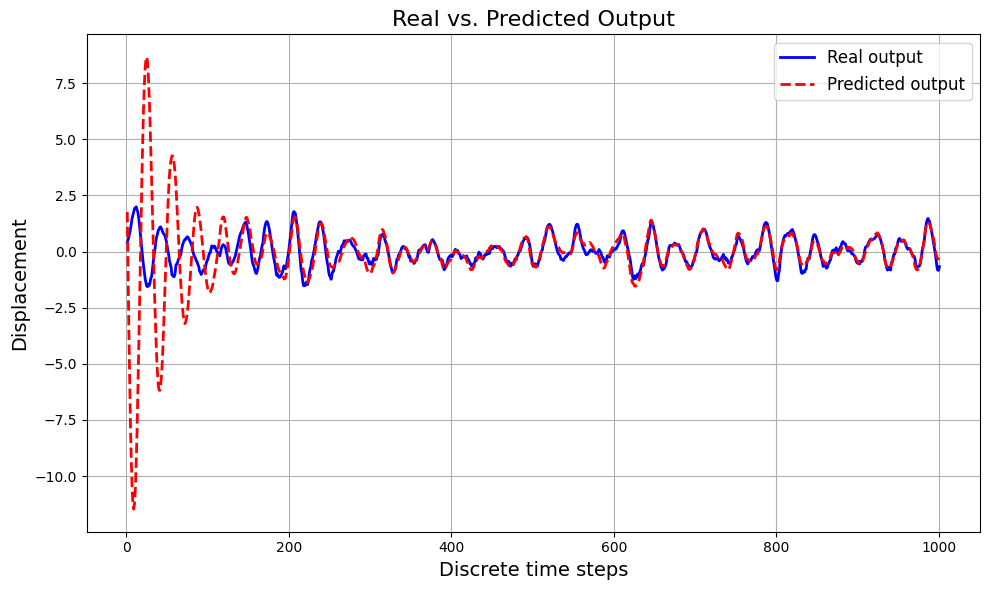

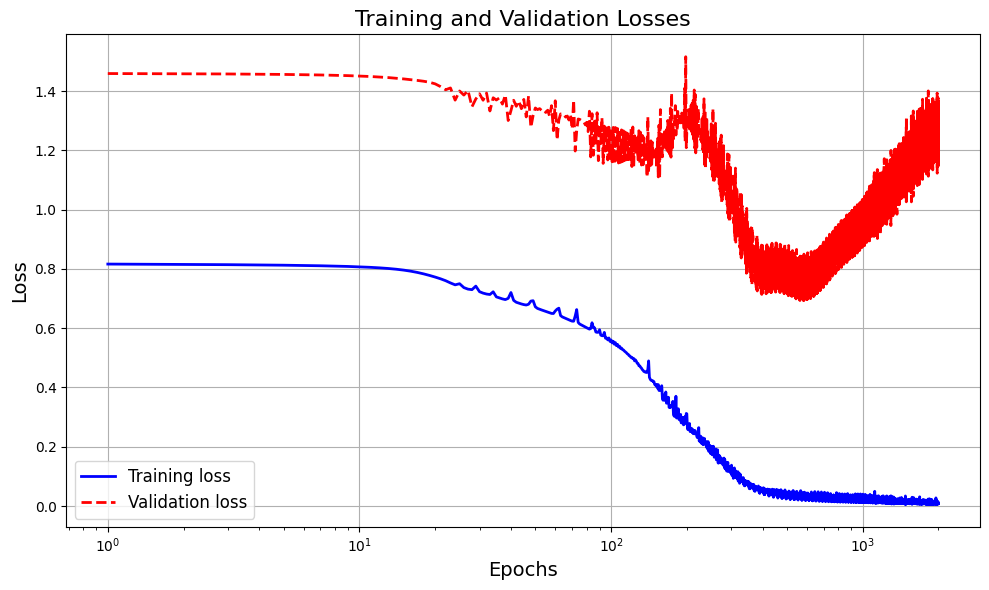

In [12]:
# Plotting the Model Predictions
time_plot = range(1, time + 2)

plt.figure(figsize=(10, 6))
plt.plot(time_plot, testPredict[0, :], 'b-', linewidth=2, label='Real output')
plt.plot(time_plot, output_test[0, :, 0], 'r--', linewidth=2, label='Predicted output')
plt.xlabel('Discrete time steps', fontsize=14)
plt.ylabel('Displacement', fontsize=14)
plt.title('Real vs. Predicted Output', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('./images/responseLSTM32.png')
plt.show()

# Plotting the Training and Validation Losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', linewidth=2, label='Training loss')
plt.plot(epochs, val_loss, 'r--', linewidth=2, label='Validation loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Losses', fontsize=16)
plt.xscale('log')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('./images/lossLSTM32.png')
plt.show()
